In [175]:
pip install numpy split-folders scikit-image keras scikit-learn matplotlib pickle tensorflow

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install tensorflow~=2.10.0

     |████████████████████████████████| 241.2 MB 29.2 MB/s eta 0:00:01    |█████████████████▏              | 129.6 MB 148 kB/s eta 0:12:35
     |████████████████████████████████| 42 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 5.9 MB 56.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 44.4 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 63.8 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorflow
    Found exis

In [44]:
import numpy as np
import os
import splitfolders
from skimage.io import imread
import random
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pickle import dump, load
import keras
import tensorflow as tf
import time
import csv
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, Xception
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

## Import dataset

In [6]:
# Get path to dataset in local computer
cwd = os.path.join(os.getcwd(), "Crochet_Stitches_Dataset_100")
cwd

'/Users/stephanieyolanda/Documents/Study/Y3S2/CM3070 Final Project/Implementation (Final)/Crochet_Stitches_Dataset_100'

In [7]:
# Get the labels from the folder names in dataset

classes = []
for file in os.scandir(cwd):
    if not file.name.startswith('.'):
        classes.append(file.name)
classes

['SC', 'DC', 'HDC']

In [8]:
if os.path.isfile('original_ds.pkl') == False:

    img_size = (224, 224)

    images, labels = [], []

    for c in classes:
        label = classes.index(c)
        for file in os.scandir(os.path.join(cwd, c)):
            if not file.name.startswith('.'):
                image = load_img(file.path, target_size=img_size)
                image = img_to_array(image)
                images.append(image)
                labels.append(label)

    original_ds = {'images': images, 
                   'labels': labels}
    dump(original_ds, open('original_ds.pkl', 'wb'))
    
else:
    original_ds = load(open('original_ds.pkl', 'rb'))
    images, labels = original_ds['images'], original_ds['labels']

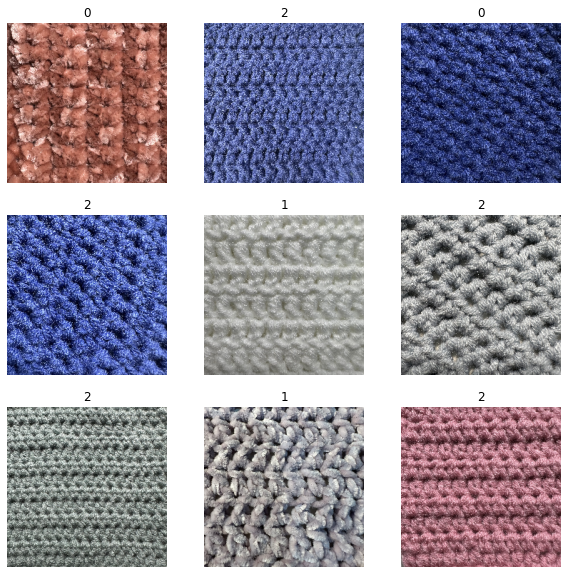

In [9]:
# Adapted from https://www.tensorflow.org/tutorials/images/data_augmentation

plt.figure(figsize=(10,10))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    index = random.randint(0, len(images)-1)
    plt.imshow(images[index].astype(np.uint8))
    plt.title(labels[index])
    plt.axis('off')

## Data pre-processing
### Reshape dataset

In [148]:
# # Convert to numpy
# X = np.array(images)
# # Convert images to grayscale
# # X = rgb2gray(X)
# # Reshape image from grayscale colorspace to rgb colorspace
# # X = np.expand_dims(X, axis=3)
# # X = X.repeat(3, axis=-1)
# # Normalize images
# X = X.astype('float32')/255

# # Convert to numpy
# y = np.array(labels)
# # Vectorize labels
# y = to_categorical(y)

# print('X:', X.shape)
# print('y:', y.shape)

X: (300, 180, 180, 3)
y: (300, 3)


In [194]:
X = np.array(images)
y = np.array(labels)
y = to_categorical(y)

[128.1348] 

[128.1348 128.1348 128.1348] 



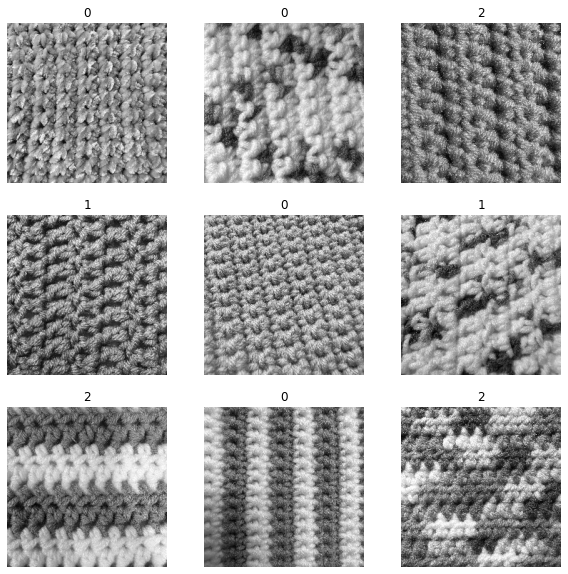

In [201]:
# # Convert images to grayscale
X_baseline_gs = rgb2gray(np.copy(X))

# Show converted images
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    index = random.randint(0, len(images)-1)
    plt.imshow(X_baseline_gs[index].astype(np.uint8), cmap='gray')
    plt.title(labels[index])
    plt.axis('off')
    
    
# Reshape image from grayscale colorspace to rgb colorspace
X_baseline_gs = np.expand_dims(X_baseline_gs, axis=3)
print(X_baseline_gs[0][0][0], '\n')
X_baseline_gs = X_baseline_gs.repeat(3, axis=-1)
print(X_baseline_gs[0][0][0], '\n')
# Normalize images
X_baseline_gs = np.copy(X)/255

In [240]:
print('Data normalization:\n')

X_baseline = np.copy(X)/255
print('Baseline', X_baseline[0][0][0])
X_xception = xception_preprocess(np.copy(X))
print('Xception', X_xception[0][0][0])
X_vgg16 = vgg16_preprocess(np.copy(X))
print('VGG16   ', X_xception[0][0][0])
X_resnet50 = resnet50_preprocess(np.copy(X))
print('ResNet50', X_xception[0][0][0])

Data normalization:

Baseline [0.5058824  0.5058824  0.45882353]
Xception [ 0.01176476  0.01176476 -0.08235294]
VGG16    [ 0.01176476  0.01176476 -0.08235294]
ResNet50 [ 0.01176476  0.01176476 -0.08235294]


### Split dataset

In [12]:
def split_dataset(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        shuffle=True, 
                                                        random_state=1, 
                                                        stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.4, 
                                                      shuffle=True, 
                                                      random_state=1, 
                                                      stratify=y_train)
    
    print('X_train:', X_train.shape)
    print('y_train:', y_train.shape)
    print('X_val  :', X_val.shape)
    print('y_val  :', y_val.shape)
    print('X_test :', X_test.shape)
    print('y_test :', y_test.shape)
    
    dataset = {'X_train' : X_train,
               'X_test': X_test,
               'X_val': X_val,
               'y_train': y_train,
               'y_test': y_test,
               'y_val': y_val}
    
    return dataset

In [151]:
print('Baseline (Grayscale):')
ds_baseline_gs = split_dataset(X_baseline_gs, y)

Baseline (Grayscale):
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)


In [13]:
print('Baseline:')
ds_baseline = split_dataset(X_baseline, y)
print('\nXception:')
ds_xception = split_dataset(X_xception, y)
print('\nVGG16:')
ds_vgg16 = split_dataset(X_vgg16, y)
print('\nResNet50:')
ds_resnet50 = split_dataset(X_resnet50, y)

Baseline:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

Xception:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

VGG16:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)

ResNet50:
X_train: (144, 224, 224, 3)
y_train: (144, 3)
X_val  : (96, 224, 224, 3)
y_val  : (96, 3)
X_test : (60, 224, 224, 3)
y_test : (60, 3)


In [14]:
def flattenX(X):
    X = X.reshape((X.shape[0], -1))
    return X

In [15]:
# X = np.array(images)
# y = np.array(labels)
# y = to_categorical(y)

### Data augmentation

In [16]:
train_gen = ImageDataGenerator(zoom_range=[0.7,1.2],
                              rotation_range=30,
                              shear_range=5,
#                               brightness_range=[1.0,1.0],
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='reflect')
#                               preprocessing_function=tf.keras.applications.xception.preprocess_input

val_gen = ImageDataGenerator()

train_aug = train_gen.flow(ds_baseline['X_train'], ds_baseline['y_train'], batch_size=16)

val_aug = val_gen.flow(ds_baseline['X_val'], ds_baseline['y_val'], batch_size=16)



# val_gen = ImageDataGenerator()
# val_aug = train_gen.flow(X_val, y_val, batch_size=16)

In [510]:
# data_aug = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)
# train_aug = data_aug.flow(X_train, y_train, batch_size=16)
# val_aug = data_aug.flow(X_val, y_val, batch_size=16)

## Build models for classification

### Initialize variables

In [212]:
INPUT_DIMENSION = ds_baseline['X_train'].shape[1:4]
OUTPUT_DIMENSION = ds_baseline['y_train'].shape[1]
LEARNING_RATE = 0.001
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
# OPTIMIZER = 'Adam'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = [CategoricalAccuracy(name='accuracy'), 
           Precision(name='precision'), 
           Recall(name='recall'),
           AUC(name='auc', multi_label=True)]
BATCH_SIZE = 16
EPOCHS = 20
MONITOR = 'val_loss'

LAYERS = {"num_layers": 0,
          "dense": [],
          "dropout": [0.5]}

In [148]:
def get_dataset_string(dataset):
    if np.array_equal(dataset, ds_baseline):
        string = 'ds_baseline'
    elif np.array_equal(dataset, ds_baseline_gs):
        string = 'ds_baseline_gs'
    elif np.array_equal(dataset, ds_xception):
        string = 'ds_xception'
    elif np.array_equal(dataset, ds_vgg16):
        string = 'ds_vgg16'
    elif np.array_equal(dataset, ds_resnet50):
        string = 'ds_resnet50'
    else:
        string = 'train_aug'
    return string

In [48]:
def get_model_params(dataset_str, layers=LAYERS,
                     input_dimension=INPUT_DIMENSION,
                     output_dimension=OUTPUT_DIMENSION,
                     optimizer=OPTIMIZER,
                     loss_function=LOSS_FUNC,
                     learning_rate=LEARNING_RATE,
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS):
    
    model_params = {'Dataset':dataset_str,
                    'Num_Layers':layers['num_layers'],
                    'Dense_Layers':layers['dense'],
                    'Dropout_Layers':layers['dropout'],
                    'Input_Dimension':input_dimension, 
                    'Output_Dimension':output_dimension,
                    'Optimizer':optimizer,
                    'Loss_Function':loss_function,
                    'Learning_Rate':learning_rate,
                    'Batch_Size':batch_size,
                    'Epochs':epochs}
    
    return model_params

### Functions for saving parameters and results to csv

In [140]:
# data can be model_params or metrics
def export_to_csv(paths, data, csv_filename):

    data = paths | data

    csv_path = os.path.join(os.getcwd(), csv_filename)
#     csv_path = 'models/'+csv_filename

    # Write to new csv if file not exist
    if not os.path.isfile(csv_path):
        with open(csv_filename, 'w') as f:
            w = csv.DictWriter(f, fieldnames=list(data.keys()))
            w.writeheader()
            w.writerow(data)
            f.close()
    # Append to existing csv
    else:
        with open(csv_filename, 'a') as f:
            w = csv.DictWriter(f, fieldnames=list(data.keys()))
            w.writerow(data)
            f.close()

### Functions for Model Building and Training

In [227]:
# params: dict containing lists of number of layers, dense, and dropout parameters (length of list = num_layers)

def build_model(pretrained_model, layers=LAYERS):
    
    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)

    if params["num_layers"] == len(params["dense"]) and (params["num_layers"] == len(params["dropout"]) or params["num_layers"] == len(params["dropout"])-1):
        
        first_dropout = False
        
        # Build on pre-trained model
        x = pretrained_model.output
        x = GlobalAveragePooling2D()(x)
        
        # Either add or don't add drop out layer before the dense layers
        if layers["num_layers"] == len(layers["dropout"])-1:
            x = Dropout(params["dropout"][0])(x)
            first_dropout = True
        
        # Add dense layers
        for layer in range(params["num_layers"]):
            x = Dense(layers["dense"][layer], activation='relu')(x)
            if first_dropout == True:
                x = Dropout(layers["dropout"][layer+1])(x)
            else:
                x = Dropout(layers["dropout"][layer])(x)

        model_outputs = Dense(OUTPUT_DIMENSION, activation='softmax')(x)
        model = Model(pretrained_model.input, model_outputs)

        model._name = model_name 
        model.compile(optimizer=OPTIMIZER, 
                      loss=LOSS_FUNC, 
                      metrics=METRICS)
        return model
    
    else:
        print("Number of dense/dropout parameters do not match number of layers")

In [51]:
# https://saturncloud.io/blog/how-to-use-pandas-to-check-if-a-row-exists-with-certain-values/

def check_model_exist(model_params, model_params_path='model_params.csv'):
    
    model_exist = False
    paths = None
    
    csv_path = os.path.join(os.getcwd(), model_params_path)
    
    if os.path.isfile(csv_path):
        df = pd.read_csv(model_params_path)
        
        df_exist = df[(df['Dataset']==str(model_params['Dataset'])) &
                        (df['Num_Layers']==int(model_params['Num_Layers'])) &
                        (df['Dense_Layers']==str(model_params['Dense_Layers'])) &
                        (df['Dropout_Layers']==str(model_params['Dropout_Layers'])) &
                        (df['Input_Dimension']==str(model_params['Input_Dimension'])) &
                        (df['Output_Dimension']==int(model_params['Output_Dimension'])) &
                        (df['Optimizer']==str(model_params['Optimizer'])) &
                        (df['Loss_Function']==str(model_params['Loss_Function'])) &
                        (df['Learning_Rate']==float(model_params['Learning_Rate'])) &
                        (df['Batch_Size']==int(model_params['Batch_Size'])) &
                        (df['Epochs']==int(model_params['Epochs']))]

        if not df_exist.empty:
            model_exist = True
            paths = {'Model_Path':df_exist['Model_Path'].values[0],
                     'History_Path':df_exist['History_Path'].values[0]}

    return model_exist, paths

In [128]:
def get_model_paths(model_name):
    timestamp = str(int(time.time()))
    model_path = "models/"+model_name+"_"+timestamp+".keras"
    history_path = "models/trained_"+model_name+"_"+timestamp+".pkl"
    
    paths = {'Model_Path':model_path,
             'History_Path':history_path}
    return paths

In [220]:
def train_model(model_name, layers, model, 
                datagen=None, 
                dataset=None, 
                ds_baseline=ds_baseline, 
                overwrite=False):
    
    if datagen != None and dataset == None:
        dataset_str = get_dataset_string(datagen)
        augmented = True
    elif dataset != None and datagen == None:
        augmented = False
        dataset_str = get_dataset_string(dataset)
    else:
        raise Exception("Choose between augmented and unaugmented dataset!")
        
    dataset_str = get_dataset_string(dataset)

    model_params = get_model_params(dataset_str)

    model_exist, model_paths = check_model_exist(model_params)
    
    if model_exist == False or overwrite == True:
        
        model_paths = get_model_paths(model_name)

        model_path, history_path = model_paths['Model_Path'], model_paths['History_Path']

        if augmented == True:
            trained_model = model.fit(train_aug,
                                      batch_size=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      validation_data=(ds_baseline['X_val'], ds_baseline['y_val']))
        else:
            augmented = False
            trained_model = model.fit(dataset['X_train'], dataset['y_train'],
                                      batch_size=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      validation_data=(dataset['X_val'], dataset['y_val']))

        # Save model locally
        save_model(model, model_path)

        # Save model history
        dump(trained_model, open(history_path, 'wb'))
        
        export_to_csv(model_paths, model_params, 'model_params.csv')

    else:
        model_path, history_path = model_paths['Model_Path'], model_paths['History_Path']
        model = load_model(model_path)
        trained_model = load(open(history_path, 'rb'))
        
    return model, trained_model

### Functions for Model Evaluation

In [54]:
def plot_history(trained_model, metric_func):
    metric = trained_model.history[metric_func]
    val_metric_func = 'val_' + metric_func
    val_metric = trained_model.history[val_metric_func]
    epochs = range(1, len(metric) + 1)
    
    
    plt.clf()
    plt.title('Training and validation ' + str(metric_func))
    plt.plot(epochs, metric, label='Training '+ str(metric_func))
    plt.plot(epochs, val_metric, label='Validation '+ str(metric_func)) 
    plt.ylabel(str(metric_func).capitalize())
    plt.legend()
    plt.show()

In [55]:
def get_results(model, X_test, y_test, model_paths, model_exist=False, labels=classes):
        
    preds = model.predict(X_test)
    
    # Calculate evaluation metrics scores
    accuracy = accuracy_score(y_test.argmax(axis=1), 
                              preds.argmax(axis=1))
    precision = precision_score(y_test.argmax(axis=1), 
                                preds.argmax(axis=1),
                                average='macro')
    recall = recall_score(y_test.argmax(axis=1), 
                          preds.argmax(axis=1),
                          average='macro')
    roc_auc = roc_auc_score(y_test, 
                            preds,
                            multi_class='ovo',
                            average='macro')

    # Print scores
    print('Score results from predicting the test set:')
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('AUC: {:.2f}'.format(roc_auc))
    
    cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    metrics = {'Accuracy':accuracy,
               'Precision':precision,
               'Recall':recall,
               'ROC_AUC':roc_auc}
    
    
    export_to_csv(model_paths, metrics, 'model_metrics.csv')

### Baseline Model

In [213]:
model_name = 'baseline_model'
dataset = ds_baseline
# dataset = ds_baseline_gs
dataset_str = get_dataset_string(dataset)

model_params = get_model_params(dataset_str)

model_exist, model_paths = check_model_exist(model_params)

if model_exist==False:
    model_paths = get_model_paths(model_name)

model_path, history_path = model_paths['Model_Path'], model_paths['History_Path']

baseline_model = Sequential()
baseline_model.add(Flatten())
baseline_model.add(Dense(OUTPUT_DIMENSION, activation='softmax'))
baseline_model._name = model_name
baseline_model.compile(optimizer=OPTIMIZER, 
                    loss=LOSS_FUNC, 
                    metrics=METRICS)

if model_exist==False:
    
#     trained_baseline_model = baseline_model.fit(train_aug,
#                                                 batch_size=BATCH_SIZE, 
#                                                 epochs=EPOCHS, 
#                                                 validation_data=val_aug,
#                                    verbose=1)
    trained_baseline_model = baseline_model.fit(dataset['X_train'], dataset['y_train'],
                                            batch_size=BATCH_SIZE, 
                                            epochs=EPOCHS, 
                                            validation_data=(dataset['X_val'], dataset['y_val']),
                                            verbose=1)
 
    # Save model locally
    save_model(baseline_model, model_path)
    
    # Save model history
    dump(trained_baseline_model, open(history_path, 'wb'))
    
    export_to_csv(model_paths, model_params, 'model_params.csv')
    
else:
    baseline_model = load_model(model_path)
    trained_baseline_model = load(open(history_path, 'rb'))

Epoch 1/20
9/9 [==============================] - 2s 84ms/step - loss: 52.2232 - accuracy: 0.3403 - precision: 0.3403 - recall: 0.3403 - auc: 0.4868 - val_loss: 69.9487 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.5000
Epoch 2/20
9/9 [==============================] - 0s 38ms/step - loss: 43.3249 - accuracy: 0.3472 - precision: 0.3472 - recall: 0.3472 - auc: 0.5152 - val_loss: 45.9832 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.5117
Epoch 3/20
9/9 [==============================] - 0s 20ms/step - loss: 32.9419 - accuracy: 0.3403 - precision: 0.3403 - recall: 0.3403 - auc: 0.5094 - val_loss: 26.6305 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.5000
Epoch 4/20
9/9 [==============================] - 0s 18ms/step - loss: 16.2468 - accuracy: 0.3889 - precision: 0.3889 - recall: 0.3889 - auc: 0.5614 - val_loss: 10.6250 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.333

In [214]:
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (16, 150528)              0         
                                                                 
 dense_25 (Dense)            (16, 3)                   451587    
                                                                 
Total params: 451,587
Trainable params: 451,587
Non-trainable params: 0
_________________________________________________________________


In [215]:
baseline_val_score = baseline_model.evaluate(dataset['X_val'], 
                                             dataset['y_val'])

3/3 [==============================] - 0s 9ms/step - loss: 1.9110 - accuracy: 0.5104 - precision: 0.5213 - recall: 0.5104 - auc: 0.6562


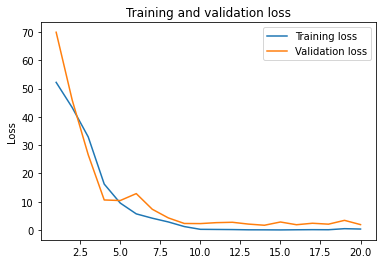

In [216]:
plot_history(trained_baseline_model, 'loss')

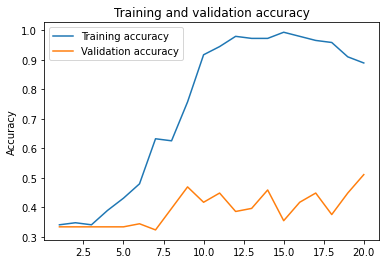

In [217]:
plot_history(trained_baseline_model, 'accuracy')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 9ms/step
Score results from predicting the test set:
Accuracy: 0.37
Precision: 0.47
Recall: 0.37
AUC: 0.52


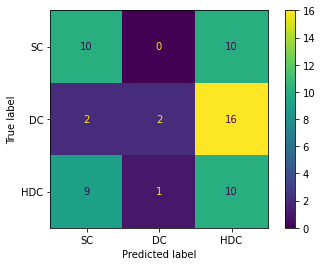

In [218]:
model_params = get_model_params(get_dataset_string(dataset))
model_exist, model_paths = check_model_exist(model_params)

metrics = get_results(baseline_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          model_exist=model_exist)

### Xception

In [225]:
model_name = 'xception_model'
dataset=ds_xception

# Pre-trained model
xception = Xception(include_top=False,
                    weights='imagenet',
                    classes=OUTPUT_DIMENSION,
                    input_shape=INPUT_DIMENSION)

xception.trainable=False

params = {"num_layers": 0,
          "dense": [],
          "dropout": [0.5]}

xception_model = build_model(xception, params)

xception_model, trained_xception_model = train_model(model_name, 
                                                     params, 
                                                     xception_model,
                                                     dataset=dataset,
                                                     overwrite=False)

Epoch 1/20
9/9 [==============================] - 23s 2s/step - loss: 1.1483 - accuracy: 0.4292 - precision: 0.4867 - recall: 0.3042 - auc: 0.6132 - val_loss: 1.1077 - val_accuracy: 0.3854 - val_precision: 0.3684 - val_recall: 0.0729 - val_auc: 0.5613
Epoch 2/20
9/9 [==============================] - 17s 2s/step - loss: 1.1297 - accuracy: 0.4167 - precision: 0.4459 - recall: 0.2292 - auc: 0.6059 - val_loss: 1.0622 - val_accuracy: 0.4896 - val_precision: 0.4545 - val_recall: 0.1042 - val_auc: 0.6500
Epoch 3/20
9/9 [==============================] - 16s 2s/step - loss: 0.9958 - accuracy: 0.5208 - precision: 0.5857 - recall: 0.2847 - auc: 0.7003 - val_loss: 1.0101 - val_accuracy: 0.5729 - val_precision: 0.6923 - val_recall: 0.0938 - val_auc: 0.6982
Epoch 4/20
9/9 [==============================] - 15s 2s/step - loss: 0.9359 - accuracy: 0.6111 - precision: 0.7143 - recall: 0.3472 - auc: 0.7582 - val_loss: 0.9874 - val_accuracy: 0.5833 - val_precision: 0.6000 - val_recall: 0.1562 - val_auc:

............1
......separable_conv2d_16
.........vars
............0
............1
......separable_conv2d_17
.........vars
............0
............1
......separable_conv2d_18
.........vars
............0
............1
......separable_conv2d_19
.........vars
............0
............1
......separable_conv2d_2
.........vars
............0
............1
......separable_conv2d_20
.........vars
............0
............1
......separable_conv2d_21
.........vars
............0
............1
......separable_conv2d_22
.........vars
............0
............1
......separable_conv2d_23
.........vars
............0
............1
......separable_conv2d_24
.........vars
............0
............1
......separable_conv2d_25
.........vars
............0
............1
......separable_conv2d_26
.........vars
............0
............1
......separable_conv2d_27
.........vars
............0
............1
......separable_conv2d_28
.........vars
............0
............1
......separable_conv2d_29
.........

In [241]:
xception_model.summary()

Model: "xception_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                    

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_115 (Add)                  (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_114[0][0]']                
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_115[0][0]']                
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_118 (

In [256]:
dataset=ds_xception

In [242]:
xception_val_score = xception_model.evaluate(dataset['X_val'], dataset['y_val'])

3/3 [==============================] - 8s 2s/step - loss: 0.8584 - accuracy: 0.5938 - precision: 0.7143 - recall: 0.4688 - auc: 0.7907


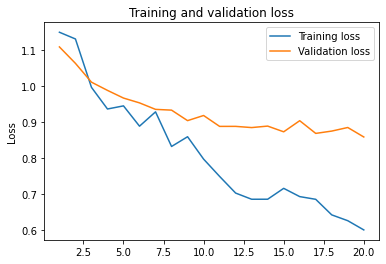

In [243]:
plot_history(trained_xception_model, 'loss')

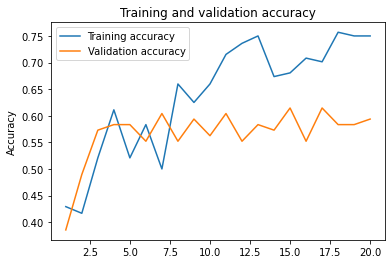

In [244]:
plot_history(trained_xception_model, 'accuracy')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 5s 2s/step
Score results from predicting the test set:
Accuracy: 0.50
Precision: 0.50
Recall: 0.50
AUC: 0.66


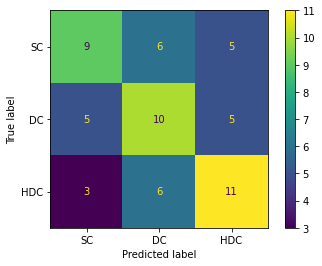

In [257]:
model_params = get_model_params(get_dataset_string(dataset))
model_exist, model_paths = check_model_exist(model_params)

metrics = get_results(xception_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          model_exist=model_exist)

### VGG16

In [246]:
model_name = 'vgg16_model'

# Pre-trained model
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              classes=OUTPUT_DIMENSION,
              input_shape=INPUT_DIMENSION)

vgg16.trainable = False

params = {"num_layers": 0,
          "dense": [],
          "dropout": [0.5]}

vgg16_model = build_model(vgg16, params)

# vgg16_model, trained_vgg16_model = train_model(model_name, params, vgg16_model, train_aug, overwrite=False)
vgg16_model, trained_vgg16_model = train_model(model_name, 
                                               params, 
                                               vgg16_model, 
                                               dataset=ds_vgg16, 
                                               overwrite=False)

Epoch 1/20
9/9 [==============================] - 37s 4s/step - loss: 6.7119 - accuracy: 0.4458 - precision: 0.4612 - recall: 0.3958 - auc: 0.5670 - val_loss: 3.0590 - val_accuracy: 0.3438 - val_precision: 0.3478 - val_recall: 0.3333 - val_auc: 0.5177
Epoch 2/20
9/9 [==============================] - 34s 4s/step - loss: 4.4935 - accuracy: 0.3542 - precision: 0.3617 - recall: 0.3542 - auc: 0.5416 - val_loss: 2.6287 - val_accuracy: 0.4167 - val_precision: 0.4176 - val_recall: 0.3958 - val_auc: 0.5701
Epoch 3/20
9/9 [==============================] - 35s 4s/step - loss: 4.9329 - accuracy: 0.3750 - precision: 0.3759 - recall: 0.3681 - auc: 0.5523 - val_loss: 2.5177 - val_accuracy: 0.4375 - val_precision: 0.4382 - val_recall: 0.4062 - val_auc: 0.5838
Epoch 4/20
9/9 [==============================] - 36s 4s/step - loss: 4.9209 - accuracy: 0.3958 - precision: 0.3957 - recall: 0.3819 - auc: 0.5591 - val_loss: 2.2730 - val_accuracy: 0.4062 - val_precision: 0.4368 - val_recall: 0.3958 - val_auc:

In [247]:
vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [249]:
dataset = ds_vgg16

In [250]:
vgg16_val_score = vgg16_model.evaluate(dataset['X_val'], dataset['y_val'])

3/3 [==============================] - 14s 5s/step - loss: 1.3560 - accuracy: 0.5208 - precision: 0.5000 - recall: 0.4375 - auc: 0.6772


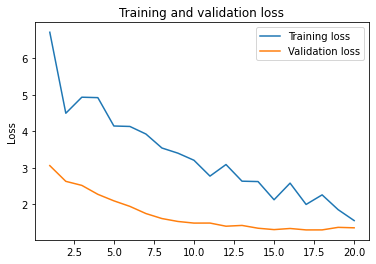

In [251]:
plot_history(trained_vgg16_model, 'loss')

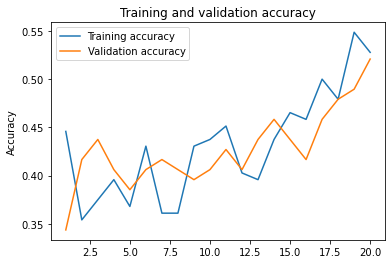

In [252]:
plot_history(trained_vgg16_model, 'accuracy')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 8s 4s/step
Score results from predicting the test set:
Accuracy: 0.52
Precision: 0.52
Recall: 0.52
AUC: 0.65


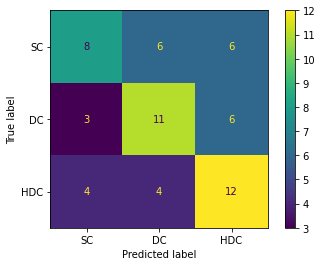

In [255]:
model_params = get_model_params(get_dataset_string(dataset))
model_exist, model_paths = check_model_exist(model_params)

metrics = get_results(vgg16_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          model_exist=model_exist)

In [202]:
get_results(vgg16_model, X_test, y_test)

1/1 [==============================] - 1s 1s/step
Score results from predicting the test set:
Accuracy: 0.57
Precision: 0.56
Recall: 0.57
AUC: 0.82


### ResNet50

In [258]:
model_name = 'resnet50_model'
dataset = ds_resnet50

# Pre-trained model
resnet50 = ResNet50(include_top=False,
              weights='imagenet',
              classes=OUTPUT_DIMENSION,
              input_shape=INPUT_DIMENSION)

resnet50.trainable = False

params = {"num_layers": 0,
          "dense": [],
          "dropout": [0.5]}

resnet50_model = build_model(resnet50, params)

# vgg16_model, trained_vgg16_model = train_model(model_name, params, vgg16_model, train_aug, overwrite=False)
resnet50_model, trained_resnet50_model = train_model(model_name, 
                                                       params, 
                                                       resnet50_model, 
                                                       dataset=dataset, 
                                                       overwrite=True)

Epoch 1/20
9/9 [==============================] - 24s 2s/step - loss: 1.9347 - accuracy: 0.4000 - precision: 0.3857 - recall: 0.3375 - auc: 0.5661 - val_loss: 1.2812 - val_accuracy: 0.4479 - val_precision: 0.4478 - val_recall: 0.3125 - val_auc: 0.5878
Epoch 2/20
9/9 [==============================] - 21s 2s/step - loss: 1.5537 - accuracy: 0.4097 - precision: 0.4341 - recall: 0.3889 - auc: 0.6107 - val_loss: 1.1340 - val_accuracy: 0.4583 - val_precision: 0.4789 - val_recall: 0.3542 - val_auc: 0.6570
Epoch 3/20
9/9 [==============================] - 17s 2s/step - loss: 1.5539 - accuracy: 0.3819 - precision: 0.4113 - recall: 0.3542 - auc: 0.5677 - val_loss: 1.0080 - val_accuracy: 0.5521 - val_precision: 0.6029 - val_recall: 0.4271 - val_auc: 0.7132
Epoch 4/20
9/9 [==============================] - 18s 2s/step - loss: 1.0841 - accuracy: 0.5139 - precision: 0.5120 - recall: 0.4444 - auc: 0.7224 - val_loss: 0.9885 - val_accuracy: 0.5312 - val_precision: 0.5606 - val_recall: 0.3854 - val_auc:

......batch_normalization_48
.........vars
............0
............1
............2
............3
......batch_normalization_49
.........vars
............0
............1
............2
............3
......batch_normalization_5
.........vars
............0
............1
............2
............3
......batch_normalization_50
.........vars
............0
............1
............2
............3
......batch_normalization_51
.........vars
............0
............1
............2
............3
......batch_normalization_52
.........vars
............0
............1
............2
............3
......batch_normalization_6
.........vars
............0
............1
............2
............3
......batch_normalization_7
.........vars
............0
............1
............2
............3
......batch_normalization_8
.........vars
............0
............1
............2
............3
......batch_normalization_9
.........vars
............0
............1
............2
............3
......conv2d
..

In [260]:
resnet50_val_score = resnet50_model.evaluate(dataset['X_val'], dataset['y_val'])

3/3 [==============================] - 7s 2s/step - loss: 0.7800 - accuracy: 0.6979 - precision: 0.7349 - recall: 0.6354 - auc: 0.8425


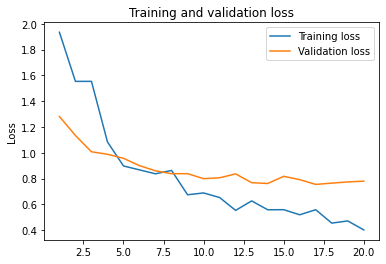

In [261]:
plot_history(trained_resnet50_model, 'loss')

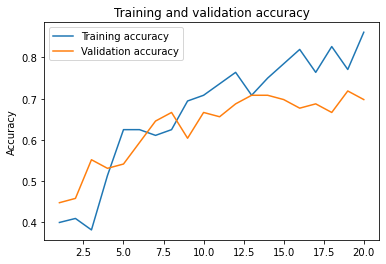

In [263]:
plot_history(trained_resnet50_model, 'accuracy')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 5s 2s/step
Score results from predicting the test set:
Accuracy: 0.62
Precision: 0.63
Recall: 0.62
AUC: 0.82


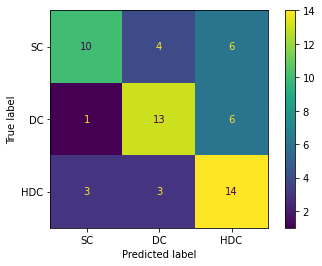

In [264]:
model_params = get_model_params(get_dataset_string(dataset))
model_exist, model_paths = check_model_exist(model_params)

metrics = get_results(resnet50_model, 
          dataset['X_test'], 
          dataset['y_test'],
          model_paths,
          model_exist=model_exist)

In [25]:
preds = resnet50_model.predict(X_test)

print('Results from predicting the test set:')

print('Accuracy: {:.2f}'.format(accuracy_score(y_test.argmax(axis=1), 
                                               preds.argmax(axis=1))))
print('Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1), 
                                                 preds.argmax(axis=1),
                                                 average='macro')))
print('Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1), 
                                           preds.argmax(axis=1),
                                           average='macro')))
print('AUC: {:.2f}'.format(roc_auc_score(y_test, 
                                         preds,
                                         multi_class='ovo',
                                         average='macro')))

1/1 [==============================] - 2s 2s/step
Results from predicting the test set:
Accuracy: 0.44
Precision: 0.29
Recall: 0.43
AUC: 0.54


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
